## 2D to 1D integral equations
The initial idea was to compute the analytic integral of the stokeslet in the arch region using sympy.
That was not possible, but it could be possible to convert the 2D integral into a 1D integral, and that should probably make the integration much faster. Let's try it out. 

### Oscillatory Stokeslet
The method is build based on the three-dimensional Unsteady Stokeslet. 

Two points $\mathbf{x}$ and $\mathbf{x_0}$, distant $r = |\mathbf{\hat{x}}|$ where $\mathbf{\hat{x}} = \mathbf{x} - \mathbf{x_0}$ from each other, are related to each other through the Unsteady Stokeslet 
$$ \mathscr{T}_{ij} (\mathbf{\hat{x}}) =  A(\lambda, r) \frac{\delta_{ij}}{r} + B(\lambda, r)\frac{\hat{x}_i \hat{x}_j}{r^3} $$
where $\lambda^2 = -\mathrm{j} \omega L^2/\nu$ is the square root of the oscillatory Reynolds number, $L$ is the flow's characteristic length.  

In [29]:
import sys
sys.path.insert(0, '..')
import quadpy
import scipy.special as sp
import matplotlib.colors as colors
import numpy as np
import time
import matplotlib.pyplot as plt
import scipy.special as sp
#sys.stdout
import tracemalloc

In [30]:

from Elastic import plate_fem as pt
from Fluid.Fluid import Fluid
from Fluid import F3D
from Fluid import F3D_1D

In [31]:
f = 1e5 # Frequency [Hz]
omega = 2*np.pi*f

# Specify geometry
l_c = 500e-6
h_c = 5e-6
w_c = 50e-6

# Specify material of beam -> Silicon
e_c = 169E9  # Young's Modulus in Pa
rho_c = 2.33E3  # Density in kg/m^3
nu_c = 0.064  # Poisson Coefficient, dimensionless
 
####  Water
mu_f = 890e-6  # Fluid dynamic viscosity in Pa.s
rho_f = 997  # Fluid density in kg/m^3
nu_f = mu_f/rho_f


lam = np.sqrt(-1j*omega*l_c**2/nu_f) 

tol_stk = 5e-4

# Basic objects, shared by all classes
geometry = pt.Geometry(l_c, w_c, h_c)
mat = pt.Material(e_c, rho_c, nu_c)
fluid = Fluid(mu_f, rho_f)

# Define grids
n_x_fluid=16
n_y_fluid=24


In [32]:
# Basic objects, shared by all classes
# Mesh specification -> To solve Kirchhoff-Love plate equation
n_x = 32  # Number of elements in length l_c (x-direction)
n_y = int(n_x*w_c/l_c) # Number of elements in width w_c (y-direction)
geometry = pt.Geometry(l_c, w_c, h_c)
mat = pt.Material(e_c, rho_c, nu_c)
fluid = Fluid(mu_f, rho_f)
plate = pt.Kirchhoff()
plate.geometry = geometry
plate.mat = mat
plate.meshing(n_x, n_y, 'crossed')
plate.preliminary_setup()
plate.k_and_m_matrices()
t_init = time.time()
vfi = F3D.F3D()
vfi.fluid = fluid
vfi.fem = plate
vfi.geometry = geometry
vfi.setup_quadrature(n_x_fluid, n_y_fluid, x_uniform=True)
vfi.tol_stk=tol_stk


In [33]:
from Fluid.h_matrix_app import *
vfi.setup_quadrature(n_x_fluid, n_y_fluid, x_uniform=True)
t_init = time.time()
tracemalloc.start()
a_out_1d_uni_app, _ = get_a_matrix_uniform(vfi.xp, vfi.yp, vfi.x, vfi.y, lam)
current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()
peak_1d_uni_app = peak
print(f"Current memory usage: {current / 1e6:.2f} MB; Peak was {peak / 1e6:.2f} MB")
tt = (time.time() - t_init)
print('1D Uniform: %d minutes and %d seconds' %(np.floor(tt/60), tt%60))
tt_1d_uni_app = tt

Current memory usage: 1.33 MB; Peak was 6.60 MB
1D Uniform: 0 minutes and 0 seconds


In [34]:
t_init = time.time()
tracemalloc.start()
a_2d = vfi.get_h_matrix(omega)
current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()
peak_2d_vfi_uni = peak
print(f"Current memory usage: {current / 1e6:.2f} MB; Peak was {peak / 1e6:.2f} MB")
tt = (time.time() - t_init)
print('1D Full time: %d minutes and %d seconds' %(np.floor(tt/60), tt%60))
tt_2d_vfi_uni = tt

Current memory usage: 1.19 MB; Peak was 2.02 MB
1D Full time: 0 minutes and 9 seconds


In [35]:
#x, xp = np.array(stk.gaussian_quad(2*n_x_fluid), dtype=object)[0][int(n_x_fluid)::], \
#        np.array(stk.gaussian_quad(2*n_x_fluid), dtype=object)[1][int(n_x_fluid)::]
#y, yp = np.array(stk.gaussian_quad(n_y_fluid), dtype=object)*w_c/2/l_c
x = vfi.x
xp = vfi.xp
y = vfi.y
yp = vfi.yp

y_plot, x_plot = np.meshgrid(y, x)


In [36]:

from Fluid.h_matrix import *
t_init = time.time()
tracemalloc.start()
a_out_1d, a_1d = get_a_matrix(xp, yp, x, y, lam)
current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()
peak_1d_full = peak
print(f"Current memory usage: {current / 1e6:.2f} MB; Peak was {peak / 1e6:.2f} MB")
tt = (time.time() - t_init)
print('1D Full time: %d minutes and %d seconds' %(np.floor(tt/60), tt%60))
tt_1d_full = tt

Current memory usage: 4.72 MB; Peak was 46.88 MB
1D Full time: 0 minutes and 17 seconds


In [37]:
t_init = time.time()
tracemalloc.start()
a_out_1d_half, a_1d_half = get_a_matrix_half(xp, yp, x, y, lam)
current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()
peak_1d_half = peak
print(f"Current memory usage: {current / 1e6:.2f} MB; Peak was {peak / 1e6:.2f} MB")
tt = (time.time() - t_init)
print('1D Half: %d minutes and %d seconds' %(np.floor(tt/60), tt%60))
tt_1d_half = tt

Current memory usage: 3.54 MB; Peak was 34.66 MB
1D Half: 0 minutes and 8 seconds


In [38]:
vfi.setup_quadrature(n_x_fluid, n_y_fluid, x_uniform=True)
t_init = time.time()
tracemalloc.start()
a_out_1d_uni, _ = get_a_matrix_uniform(vfi.xp, vfi.yp, vfi.x, vfi.y, lam)
tt = (time.time() - t_init)
current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()
peak_1d_uni = peak
print(f"Current memory usage: {current / 1e6:.2f} MB; Peak was {peak / 1e6:.2f} MB")
print('1D Uniform: %d minutes and %d seconds' %(np.floor(tt/60), tt%60))
tt_1d_uni = tt

Current memory usage: 1.33 MB; Peak was 5.08 MB
1D Uniform: 0 minutes and 1 seconds


In [39]:

from Fluid.h_matrix_app import *
t_init = time.time()
tracemalloc.start()
a_out_1d_mid_app, _ = get_a_matrix_uniform_mid(vfi.xp, vfi.yp, vfi.x, vfi.y, lam)
tt = (time.time() - t_init)
current, peak = tracemalloc.get_traced_memory()
print(f"Current memory usage: {current / 1e6:.2f} MB; Peak was {peak / 1e6:.2f} MB")

tracemalloc.stop()
print('1D Full time: %d minutes and %d seconds' %(np.floor(tt/60), tt%60))
tt_1d_mid_app_uni = tt
peak_1d_mid_app_uni = peak

Current memory usage: 1.26 MB; Peak was 5.06 MB
1D Full time: 0 minutes and 0 seconds


Current memory usage: 0.01 MB; Peak was 2.37 MB
Solution time: 0 minutes and 0 seconds


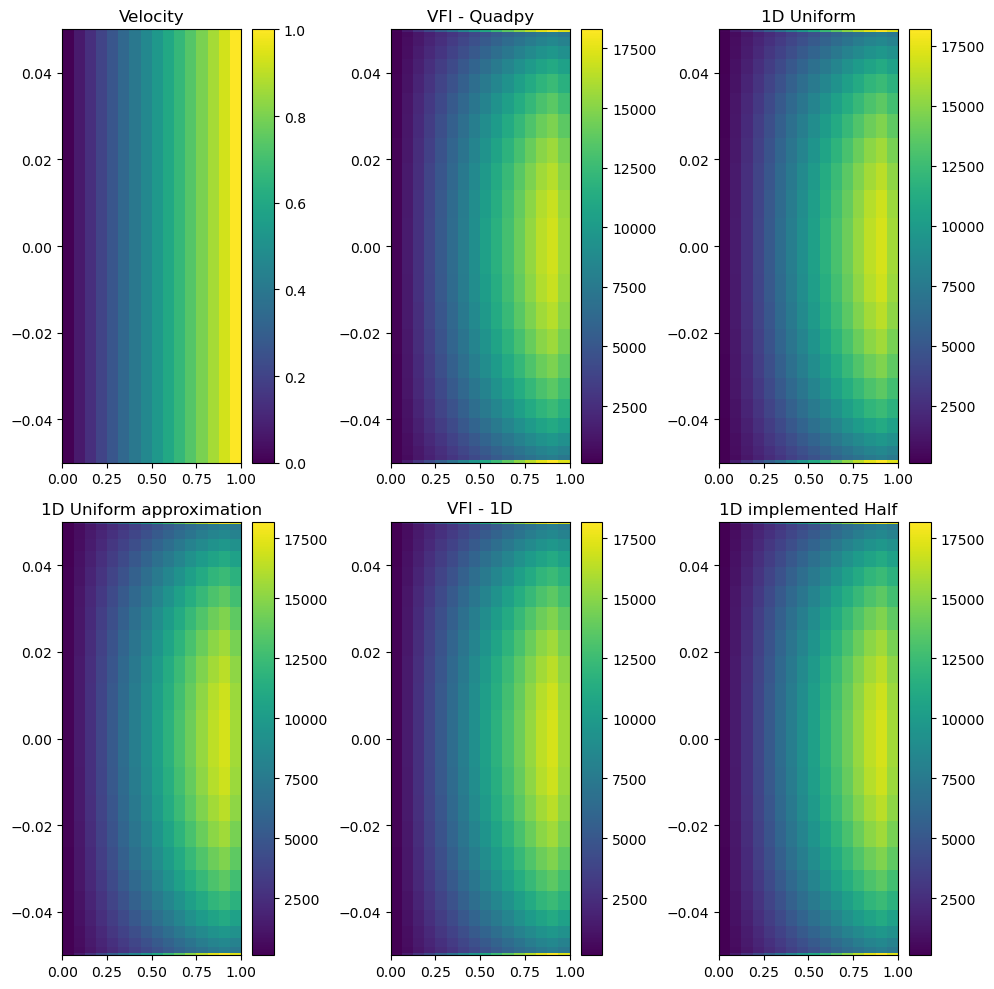

In [40]:
v1 = np.linspace(0, 1, n_x_fluid)
v2 = np.tile(v1, (n_y_fluid, 1))
v = v2.T.flatten()#v = np.ones(n_x_fluid*n_y_fluid)
t_init = time.time()
tracemalloc.start()
p_2d_vfi = np.linalg.solve(a_2d, v)
tt = (time.time() - t_init)
current, peak = tracemalloc.get_traced_memory()
print(f"Current memory usage: {current / 1e6:.2f} MB; Peak was {peak / 1e6:.2f} MB")

tracemalloc.stop()
print('Solution time: %d minutes and %d seconds' %(np.floor(tt/60), tt%60))
tt_solve = tt
peak_solve = peak

#p_quadpy_2d_here = np.linalg.solve(a_init, v)
#p_quadpy_2d = np.linalg.solve(a2_out, v)
p_1d_uni = np.linalg.solve(a_out_1d_uni, v)
p_1d_uni = p_1d_uni.T.reshape(n_x_fluid, n_y_fluid)

p_1d_uni_app = np.linalg.solve(a_out_1d_uni_app, v)
p_1d_uni_app = p_1d_uni_app.T.reshape(n_x_fluid, n_y_fluid)


p_1d_uni_mid_app = np.linalg.solve(a_out_1d_mid_app, v)
p_1d_uni_mid_app = p_1d_uni_mid_app.T.reshape(n_x_fluid, n_y_fluid)
#p_1d_uni_app_pre = np.linalg.solve(a_out_1d_uni_app_pre, v)
#p_1d_uni_app_pre = p_1d_uni_app_pre.T.reshape(n_x_fluid, n_y_fluid)

p_1d_implemented = np.linalg.solve(a_out_1d, v)
p_1d_implemented_half = np.linalg.solve(a_out_1d_half, v)

#p_new = np.linalg.solve(a2_out, v)
#p_old = np.linalg.solve(a_init, v)

p_2d_vfi = p_2d_vfi.T.reshape(n_x_fluid, n_y_fluid)

#p_1d_here = np.abs(p_1d_here).T.reshape(n_x_fluid, n_y_fluid)
p_1d = p_1d_implemented.T.reshape(n_x_fluid, n_y_fluid)
p_1d_half = p_1d_implemented_half.T.reshape(n_x_fluid, n_y_fluid)

plt.figure(figsize=(10, 10))
plt.subplot(2, 3, 1)
plt.title('Velocity')
p = plt.pcolormesh(x_plot, y_plot, v2.T)
plt.colorbar(p)

plt.subplot(2, 3, 2)
plt.title('VFI - Quadpy')
p = plt.pcolormesh(x_plot, y_plot, np.abs(p_2d_vfi))
plt.colorbar(p)

plt.subplot(2, 3, 3)
plt.title('1D Uniform')
p = plt.pcolormesh(x_plot, y_plot, np.abs(p_1d_uni))
plt.colorbar(p)

plt.subplot(2, 3, 4)
plt.title('1D Uniform approximation')
p = plt.pcolormesh(x_plot, y_plot, np.abs(p_1d_uni_app))
plt.colorbar(p)

plt.subplot(2, 3, 5)
plt.title('VFI - 1D')
p = plt.pcolormesh(x_plot, y_plot, np.abs(p_1d))
plt.colorbar(p)

plt.subplot(2, 3, 6)
plt.title('1D implemented Half')
p = plt.pcolormesh(x_plot, y_plot, np.abs(p_1d_uni_mid_app))
plt.colorbar(p)
plt.tight_layout()
plt.savefig('Figures/Pressure_maps.png')

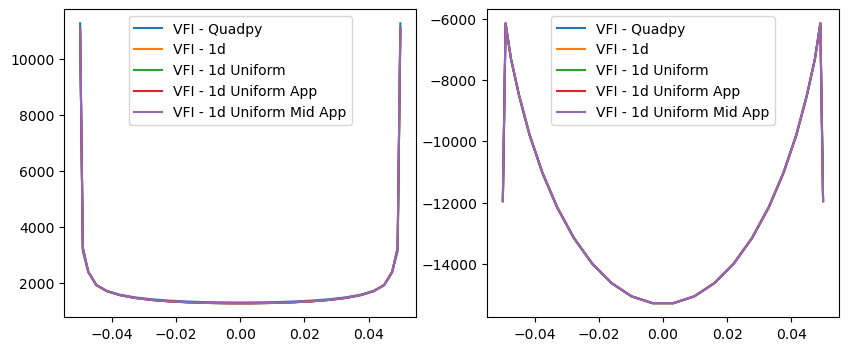

In [41]:
ix = n_x_fluid-4#10
iy = n_y_fluid-1#2
#a_plot = np.real(a_vec[ix*n_x_fluid:(ix+1)*n_x_fluid, iy*n_y_fluid:(iy+1)*n_y_fluid])##

#p = plt.pcolormesh(  a_plot.T)
#plt.colorbar(p)


plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(yp, np.real(p_2d_vfi[ix, :]), label='VFI - Quadpy')
plt.plot(yp, np.real(p_1d[ix, :]), label='VFI - 1d')
plt.plot(yp, np.real(p_1d_uni[ix, :]), label='VFI - 1d Uniform')
plt.plot(yp, np.real(p_1d_uni_app[ix, :]), label='VFI - 1d Uniform App')
plt.plot(yp, np.real(p_1d_uni_mid_app[ix, :]), label='VFI - 1d Uniform Mid App')
plt.legend(fontsize=(10))

plt.subplot(1, 2, 2)
plt.plot(yp, np.imag(p_2d_vfi[ix, :]), label='VFI - Quadpy')
plt.plot(yp, np.imag(p_1d[ix, :]), label='VFI - 1d')
plt.plot(yp, np.imag(p_1d_uni[ix, :]), label='VFI - 1d Uniform')
plt.plot(yp, np.imag(p_1d_uni_app[ix, :]), label='VFI - 1d Uniform App')
plt.plot(yp, np.imag(p_1d_uni_mid_app[ix, :]), label='VFI - 1d Uniform Mid App')
plt.legend(fontsize=(10))
plt.savefig('Figures/Pressure_comparison.png')

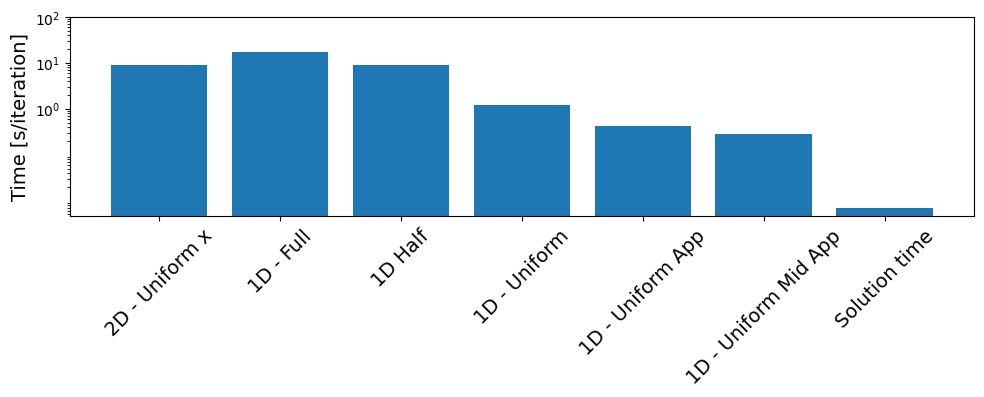

In [42]:
fig = plt.figure(figsize=(10, 4))
#ax = fig.add_axes([0,0,1,1])
ax = plt.subplot(1, 1, 1)
types = ['2D - Uniform x', '1D - Full','1D Half', '1D - Uniform', 
         '1D - Uniform App' , '1D - Uniform Mid App', 'Solution time']
times = [tt_2d_vfi_uni,  tt_1d_full,  tt_1d_half, tt_1d_uni,  tt_1d_uni_app,
         tt_1d_mid_app_uni, tt_solve]
ax.bar(types,times)
plt.ylabel('Time [s/iteration]', fontsize=14)
plt.xticks(fontsize=14, rotation=45)
plt.tight_layout()
plt.yscale('log')
plt.yticks([1, 10, 100])
plt.savefig('Figures/Computation_time.png', dpi=400)
plt.show()

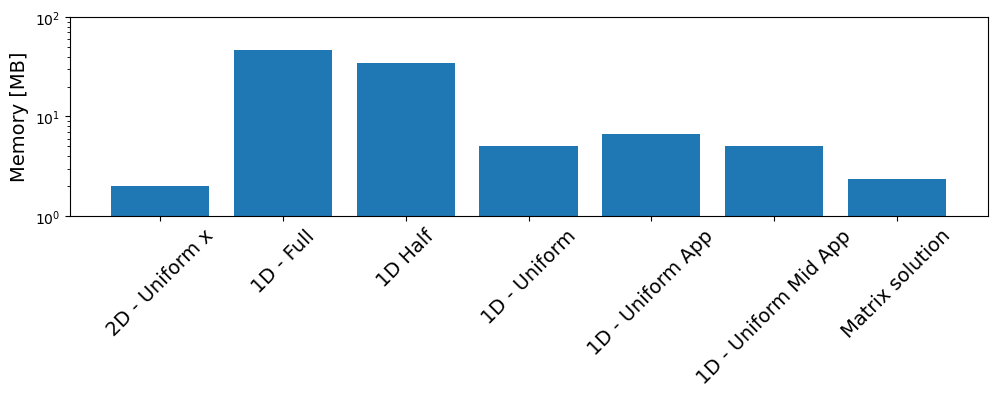

In [43]:
fig = plt.figure(figsize=(10, 4))
#ax = fig.add_axes([0,0,1,1])
ax = plt.subplot(1, 1, 1)
types = [ '2D - Uniform x', '1D - Full','1D Half', '1D - Uniform', 
         '1D - Uniform App' , '1D - Uniform Mid App', 'Matrix solution']
mem = [ peak_2d_vfi_uni,  peak_1d_full,  peak_1d_half, peak_1d_uni,  peak_1d_uni_app,
         peak_1d_mid_app_uni, peak_solve]
mem = np.array(mem)/1e6
ax.bar(types,mem)
plt.ylabel('Memory [MB]', fontsize=14)
plt.xticks(fontsize=14, rotation=45)
plt.tight_layout()
plt.yscale('log')
plt.yticks([1, 10, 100])
plt.savefig('Figures/Memory_usage.png', dpi=400)
plt.show()